# Localizable entanglement in 2D cluster states

In this notebook we compute the localizable entanglement of 2D ladder cluster states. The entanglement is computed for the two qubits on opposite corners of the graph, and it is computed as the average over the localizable entanglemen for all the $N/2$ paths connecting these two qubits

In [1]:
### loading some modules 
import numpy as np
import networkx as nx
import itertools

from qutip import *
from qutip.qip.operations import cnot, snot, ry
from qutip.qip.circuit import QubitCircuit
from qutip.qip.qubits import qubit_states
import matplotlib.pyplot as plt 

import cirq
import qutrit_utils

In [2]:
###
#     Functions to construct the qubit graph
###
##-- return the indices of the neighbors of a given qubit
def qubit_neighbor_indices(qubit, qubits):
    
    neighbor_list = list(qubit.neighbors(qubits))
    index_neighbor_list = []
    
    for nn in range(len(neighbor_list)):
        index_neighbor_list.append(qubits.index(neighbor_list[nn]))
    #
    return index_neighbor_list
#

##-- construct the graph of the 2D cluster state under consideration
def build_qubit_graph(num_qubits):
    qus = cirq.GridQubit.rect(rows = int(num_qubits/2), cols = 2)
    
    qubit_graph = nx.Graph()
    qubit_graph.add_nodes_from(range(num_qubits))
    
    for nn in range(num_qubits):
        ind_neighbors = qubit_neighbor_indices(qus[nn], qus)
        
        for ii in ind_neighbors:
            if (nn, ii) not in qubit_graph.edges():
                qubit_graph.add_edge(nn,ii)
            #
        #
    #
    
    return qubit_graph
#

In [3]:
###
#   some other utility functions
###
##-- compute the localizable netanglement based on the negativity
def negativity(rho, Nq):
    return((partial_transpose(rho, [0,1])).norm()-1)/2
#

In [7]:
###
#      Functions to compute the localizable entanglements
###
##-- get all the projectors
def get_projector_path(Nq, path):
    projs=[]

    Tx = Qobj(np.array([[1.0/np.sqrt(2), -1.0/np.sqrt(2)],
                     [1.0/np.sqrt(2), 1.0/np.sqrt(2)]]),dims=[[2],[2]])
    Tz = Qobj(np.array([[1.0, 0.0],
                     [0.0, 1.0]]),dims=[[2],[2]])
    
    ex = Tx*qubit_states(N=1, states=[1])
    gx = Tx*qubit_states(N=1, states=[0])
    ez = Tz*qubit_states(N=1, states=[1])
    gz = Tz*qubit_states(N=1, states=[0])
    
    
    gpx = gx.proj()
    epx = ex.proj()
    gpz = gz.proj()
    epz = ez.proj()
    
    identity = Qobj(np.identity(2),dims=[[2],[2]])
    
    pros_x = [gpx, epx]
    pros_z = [gpz, epz]
        
    projector = [0]*Nq
    
    for pp in range(Nq):
        if pp == 0 or pp == Nq-1:
            projector[pp] = identity
        elif pp not in path:
            projector[pp] = pros_z[np.random.choice([0,1])]
        else:
            projector[pp] = pros_x[np.random.choice([0,1])]
        #
    #
    return tensor(projector)
#

##-- use the projectors to compute the localizable negativity
def loc_neg(rho1, projs, Nq):
    neglist = []
    
    for pp in range(len(projs)):
        p = projs[pp]
        
        projected = (p*rho1)
        ps = projected.tr()
                
        if ps != 0:
            rho = (1/ps)*projected.ptrace([0, Nq-1])
        else:
            rho = 0*projected.ptrace([0, Nq-1])
        #
        neg = negativity(rho, 2)
        neglist.append(neg)
    #
    return np.mean(neglist)
#

def loc_ent_half_length_path(rho, Nq):
    ##-- construct of the paths of length Nq/2 - 1 beggining at qubit 0 and ending at qubit Nq-1
    qgraph = build_qubit_graph(Nq)
    qpaths = [path for path in nx.all_shortest_paths(qgraph,0,Nq-1)]
    
    negs = []
    
    for qpath in qpaths:
        projs = [get_projector_path(Nq, qpath) for ii in range(256)]
        negs.append(loc_neg(rho, projs, Nq))
    #
    return negs
#   

## Fidelity of prepared cluster state

In [8]:
qutrit_utils.leak_cluster_state_2D(4,0,0,0)

┌────────────────────┐                   ┌──┐
0 (d=3): ───[H]───[Q3_CZ]───[pi_ef]────[CX_Q3_Q2]──────────────[H]───[Q3_CZ]────X─────
                  │                    │                             │          │
1 (d=3): ───[H]───@─────────[pi_ef]────┼─────────[CX_Q3_Q2]────[H]───@──────────┼X────
                                       │         │                              ││
2: ────────────────────────────────────┼─────────┼──────────────────────────────X┼────
                                       │         │                               │
3: ────────────────────────────────────┼─────────┼───────────────────────────────X────
                                       │         │
4: ────────────────────────────────────@─────────┼────────────────────────────────────
                                                 │
5: ──────────────────────────────────────────────@────────────────────────────────────
                                      └────────────────────┘                   └──┘

## System parameters

In [9]:
### system parameters
qus = [2,4,6,8,10]

waittimes = [0.125, 0.2, 0.125, 0.125, 0.075, 0.205, 0.275]
coherence_times1 = [27, 22, 16, 12]
coherence_times2 = [22, 23, 4, 6]

nparams = [0.035, 0.02, 0.01, 0.045]

## 1) The ideal cluster state

### creating the states

In [10]:
%%time
##-- initialize the simulators
simulator = cirq.Simulator()
dsim = cirq.DensityMatrixSimulator()

ideal_states = []

for qu in qus:

    ideal_cluster_state_2d = simulator.simulate(qutrit_utils.leak_cluster_state_2D(qu, 0.0, 0.0, 0.0)).final_state_vector

    big_ideal_rho = Qobj(np.outer(ideal_cluster_state_2d,ideal_cluster_state_2d), dims = [[3,3]+[2]*qu,[3,3]+[2]*qu], shape = [9*2**qu, 9*2**qu])
    
    ideal_rho = ptrace(big_ideal_rho, list(range(2, qu+2)))
    
    ideal_states.append(ideal_rho)
#
len(ideal_states)

CPU times: user 1.21 s, sys: 251 ms, total: 1.46 s
Wall time: 1.51 s


5

### computing the localizable entanglement

In [11]:
%%time
mean_neg_ide = []
std_neg_ide = []

for qq in range(len(qus)):
    qu = qus[qq]
    
    nega = loc_ent_half_length_path(ideal_states[qq], qu)
    
    mean_neg_ide.append(np.mean(nega))
    std_neg_ide.append(np.std(nega))
    print(nega)
#

[0.5]
[0.5, 0.5]
[0.49999999999999994, 0.49999999999999994, 0.49999999999999994]
[0.5000000000000001, 0.5000000000000001, 0.5000000000000001, 0.5000000000000001]
[0.4999999999999998, 0.4999999999999998, 0.4999999999999998, 0.4999999999999998, 0.4999999999999998]
CPU times: user 21.1 s, sys: 68.4 ms, total: 21.2 s
Wall time: 21.4 s


## 2) The coherence limit

### creating the states

In [12]:
%%time
deco_states = []

for qu in qus:

    deco_cluster_state_2d = dsim.simulate(qutrit_utils.noisy_cluster_state_2D(qu, waittimes, coherence_times1, coherence_times2, [0.0,0.0,0.0,0.0])).final_density_matrix
    
    big_deco_rho = Qobj(deco_cluster_state_2d, dims = [[3,3]+[2]*qu,[3,3]+[2]*qu], shape = [9*2**qu, 9*2**qu])
    
    deco_rho = ptrace(big_deco_rho, list(range(2, qu+2)))
    
    deco_states.append(deco_rho)
#

CPU times: user 34.4 s, sys: 6.65 s, total: 41.1 s
Wall time: 36.3 s


### computing the localizable entanglement

In [13]:
%%time
mean_neg_deco = []
std_neg_deco = []

for qq in range(len(qus)):
    qu = qus[qq]
    
    nega = loc_ent_half_length_path(deco_states[qq], qu)
    
    mean_neg_deco.append(np.mean(nega))
    std_neg_deco.append(np.std(nega))
    print(nega)
#

[0.4787889604159117]
[0.43619176502222634, 0.44327403116371333]
[0.4081983890588501, 0.4121148953792686, 0.41184134146520324]
[0.3788690112027341, 0.38228112687286864, 0.3852835222337257, 0.37764631035472657]
[0.35103641331133406, 0.3536724974651867, 0.356716728571436, 0.3515105336351365, 0.3442411192952789]
CPU times: user 21.5 s, sys: 1.32 s, total: 22.8 s
Wall time: 21.3 s


## 3) The noisy states

### creating the states

In [14]:
%%time
noisy_states = []

for qu in qus:

    noisy_cluster_state_2d = dsim.simulate(qutrit_utils.noisy_cluster_state_2D(qu, waittimes, coherence_times1, coherence_times2, nparams)).final_density_matrix    
    
    big_noisy_rho = Qobj(noisy_cluster_state_2d, dims = [[3,3]+[2]*qu,[3,3]+[2]*qu], shape = [9*2**qu, 9*2**qu])
    
    noisy_rho = ptrace(big_noisy_rho, list(range(2, qu+2)))
    
    noisy_states.append(noisy_rho)
#

CPU times: user 42.4 s, sys: 17.1 s, total: 59.5 s
Wall time: 37.5 s


### computing the localizable entanglement

In [15]:
%%time
mean_neg_noisy = []
std_neg_noisy = []

for qq in range(len(qus)):
    qu = qus[qq]

    nega = loc_ent_half_length_path(noisy_states[qq], qu)

    mean_neg_noisy.append(np.mean(nega))
    std_neg_noisy.append(np.std(nega))
    print(nega)
#

[0.4641193118012963]
[0.37402689844613124, 0.3930507823791194]
[0.3282886411557557, 0.34434395356102476, 0.33195383718749216]
[0.2833480471476832, 0.28655679563303893, 0.273934660666401, 0.28014212902104596]
[0.23571571044392653, 0.24361103512217686, 0.23707534534124575, 0.23269792260595357, 0.23757448104875847]
CPU times: user 21.4 s, sys: 119 ms, total: 21.5 s
Wall time: 22.3 s


## Plot!

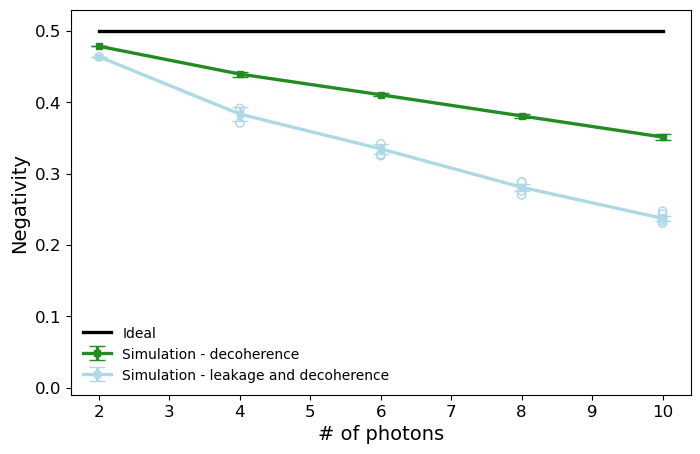

In [17]:
fig, ax = plt.subplots(figsize=(8,5))

n_full = [[0.4641193118012963],
[0.39164549277785776, 0.37130043283097525],
[0.34191755170152094, 0.32530831033411456, 0.3268258321972514],
[0.28796429354546016, 0.27589398109679525, 0.2885039149697778, 0.27031179367497843],
[0.24723002684411757, 0.23070841198646297, 0.243294903349436, 0.2364447380233905, 0.23363971425749303]]

ax.plot(qus, mean_neg_ide, "-", label = "Ideal", lw = 2.4, c = "black")

ax.errorbar(qus, mean_neg_deco, yerr = std_neg_deco, label = "Simulation - decoherence",
            lw = 2.4, c = "forestgreen", capsize=6, marker = "s", markersize = 4)

for aa in range(len(n_full)):
    plt.scatter([qus[aa]]*(int(qus[aa]/2)), n_full[aa], facecolors = "none", edgecolors = "lightblue")
#
ax.errorbar(qus, mean_neg_noisy, yerr = std_neg_noisy, label = "Simulation - leakage and decoherence",
            lw = 2.4, c = "lightblue", capsize=6, marker = "s", markersize = 4)

ax.set_ylim(-0.01,0.53)
ax.legend(frameon = False)
ax.set_ylabel('Negativity', fontsize = 14)
ax.set_xlabel('# of photons', fontsize = 14)
ax.tick_params(axis = "both", labelsize = 12)

plt.show()